In [24]:
# %%
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from tqdm.auto import tqdm

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

from typing import Any, Callable, Sequence, Union
import numpy as np
import scipy.stats as stats

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange, repeat
import wandb

from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaborLayerLogSigma_, GaussianLayerGamma, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

In [25]:
config = {
    "BATCH_SIZE": 64,
    "EPOCHS": 500,
    "LEARNING_RATE": 3e-3,
    "INITIAL_LR": 1e-2,
    "PEAK_LR": 4e-2,
    "END_LR": 5e-3,
    "WARMUP_EPOCHS": 15,
    "SEED": 42,
    "GDN_CLIPPING": True,
    "NORMALIZE_PROB": False,
    "NORMALIZE_ENERGY": True,
    "ZERO_MEAN": True,
    "USE_BIAS": False,
    "CS_KERNEL_SIZE": 21,
    "GDNGAUSSIAN_KERNEL_SIZE": 11,
    "GABOR_KERNEL_SIZE": 31,
    "N_SCALES": 4,
    "N_ORIENTATIONS": 16,
    # "N_GABORS": 128,
    "USE_GAMMA": True,
    "INIT_JH": True,
    "INIT_GABOR": True,
    "TRAIN_JH": False,
    "TRAIN_CS": False,
    "TRAIN_GABOR": False,
    "A_GABOR": False,
    "A_GDNSPATIOFREQORIENT": False,
    "TRAIN_ONLY_LAST_GDN": True,
}
config = ConfigDict(config)
config

A_GABOR: false
A_GDNSPATIOFREQORIENT: false
BATCH_SIZE: 64
CS_KERNEL_SIZE: 21
END_LR: 0.005
EPOCHS: 500
GABOR_KERNEL_SIZE: 31
GDNGAUSSIAN_KERNEL_SIZE: 11
GDN_CLIPPING: true
INITIAL_LR: 0.01
INIT_GABOR: true
INIT_JH: true
LEARNING_RATE: 0.003
NORMALIZE_ENERGY: true
NORMALIZE_PROB: false
N_ORIENTATIONS: 16
N_SCALES: 4
PEAK_LR: 0.04
SEED: 42
TRAIN_CS: false
TRAIN_GABOR: false
TRAIN_JH: false
TRAIN_ONLY_LAST_GDN: true
USE_BIAS: false
USE_GAMMA: true
WARMUP_EPOCHS: 15
ZERO_MEAN: true

In [26]:
# %%
class ChromaFreqOrientGaussianGamma(nn.Module):
    """(1D) Gaussian interaction between gamma_fuencies and orientations optimizing gamma = 1/sigma instead of sigma."""
    use_bias: bool = False
    strides: int = 1
    padding: str = "SAME"
    bias_init: Callable = nn.initializers.zeros_init()
    n_scales: Sequence[int] = jnp.array([4, 2, 2], dtype=jnp.int32)
    n_orientations: Sequence[int] = jnp.array([8, 8, 8], dtype=jnp.int32)

    @nn.compact
    def __call__(self,
                    inputs,
                    fmean,
                    theta_mean,
                    **kwargs,
                    ):

        gamma_f_a = self.param("gamma_f_a",
                                k_array(1/0.4, arr=jnp.array([2.,4.,8.,16.])),
                                (self.n_scales[0],))
        gamma_theta_a = self.param("gamma_theta_a",
                                    nn.initializers.ones_init(),
                                #  (self.n_orientations[0],))
                                    (8,))

        gamma_f_t = self.param("gamma_f_t",
                                k_array(1/0.4, arr=jnp.array([3.,6.])),
                                (self.n_scales[1],))
        gamma_theta_t = self.param("gamma_theta_t",
                                    nn.initializers.ones_init(),
                                #  (self.n_orientations[1],))
                                    (8,))

        gamma_f_d = self.param("gamma_f_d",
                                k_array(1/0.4, arr=jnp.array([3.,6.])),
                                (self.n_scales[2],))
        gamma_theta_d = self.param("gamma_theta_d",
                                    nn.initializers.ones_init(),
                                #  (self.n_orientations[2],))
                                    (8,))

        H_cc = self.param("H_cc",
                            nn.initializers.ones_init(),
                            (3,3))

        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (len(fmean),))
        else: bias = 0.
        # n_groups = inputs.shape[-1] // len(fmean)

        ## Repeat gammas
        gamma_f = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_f = jnp.tile(gamma_f, reps=2)
        gamma_theta = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([gamma_f_a, gamma_f_t, gamma_f_d], [gamma_theta_a, gamma_theta_t, gamma_theta_d])])
        gamma_theta = jnp.tile(gamma_theta, reps=2)

        ## Repeating
        cc = jnp.array([0,1,2])
        cc = jnp.repeat(cc, repeats=jnp.array([64,32,32]), total_repeat_length=len(fmean))

        kernel = jax.vmap(self.gaussian, in_axes=(None,None,0,0,0,0,None,0,None,None), out_axes=1)(fmean, theta_mean, fmean, theta_mean, gamma_f, gamma_theta, cc, cc, H_cc, 1)
        kernel = kernel[None,None,:,:]

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv_general_dilated(
                jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        if not had_batch: outputs = outputs[0]
        return outputs + bias

    @staticmethod
    def gaussian(f, theta, fmean, theta_mean, gamma_f, gamma_theta, c_1, c_2, H_cc, A=1):
        return H_cc[c_1,c_2]*A*jnp.exp(-((gamma_f**2)*(f-fmean)**2)/(2))*jnp.exp(-((gamma_theta**2)*(theta-theta_mean)**2)/(2))

# %%
class GDNSpatioChromaFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                    inputs,
                    fmean,
                    theta_mean,
                    train=False,
                    ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                            #equal_to(inputs_star/10),
                            self.bias_init,
                            (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FOG = ChromaFreqOrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FOG(outputs, fmean=fmean, theta_mean=theta_mean)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return self.param("B", nn.initializers.ones_init(), (outputs.shape[-1],))*inputs / (jnp.clip(outputs+bias, a_min=1e-5)**self.epsilon + self.eps)

# %%
class GaborLayerGammaHumanLike_(nn.Module):
    """Parametric Gabor layer with particular initialization."""
    n_scales: Sequence[int] # [A, T, D]
    n_orientations: Sequence[int] # [A, T, D]

    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    feature_group_count: int = 1

    use_bias: bool = False
    xmean: float = 0.5
    ymean: float = 0.5
    fs: float = 1 # Sampling frequency
    phase = jnp.array([0., jnp.pi/2.])

    normalize_prob: bool = True
    normalize_energy: bool = False
    zero_mean: bool = False
    train_A: bool = False

    @nn.compact
    def __call__(self,
                    inputs,
                    train=False,
                    return_freq=False,
                    return_theta=False,
                    ):
        total_scales = jnp.sum(jnp.array(self.n_scales))
        total_orientations = jnp.sum(jnp.array(self.n_orientations))
        features = jnp.sum(jnp.array([s*o*len(self.phase) for s, o in zip(self.n_scales, self.n_orientations)]))

        is_initialized = self.has_variable("precalc_filter", "kernel")
        precalc_filters = self.variable("precalc_filter",
                                        "kernel",
                                        jnp.zeros,
                                        (self.kernel_size, self.kernel_size, inputs.shape[-1], features))
        freq_a = self.param("freq_a",
                            freq_scales_init(n_scales=self.n_scales[0], fs=self.fs),
                            (self.n_scales[0],))
        gammax_a = self.param("gammax_a",
                            k_array(k=0.4, arr=1/(freq_a**0.8)),
                            (self.n_scales[0],))
        gammay_a = self.param("gammay_a",
                            equal_to(gammax_a*0.8),
                            (self.n_scales[0],))
        theta_a = self.param("theta_a",
                            linspace(start=0, stop=jnp.pi, num=self.n_orientations[0]),
                            (self.n_orientations[0],))
        sigma_theta_a = self.param("sigma_theta_a",
                                    equal_to(theta_a),
                                    (self.n_orientations[0],))

        freq_t = self.param("freq_t",
                            freq_scales_init(n_scales=self.n_scales[1], fs=self.fs),
                            (self.n_scales[1],))
        gammax_t = self.param("gammax_t",
                            k_array(k=0.4, arr=1/(freq_t**0.8)),
                            (self.n_scales[1],))
        gammay_t = self.param("gammay_t",
                            equal_to(gammax_t*0.8),
                            (self.n_scales[1],))
        theta_t = self.param("theta_t",
                            linspace(start=0, stop=jnp.pi, num=self.n_orientations[1]),
                            (self.n_orientations[1],))
        sigma_theta_t = self.param("sigma_theta_t",
                                    equal_to(theta_t),
                                    (self.n_orientations[1],))

        freq_d = self.param("freq_d",
                            freq_scales_init(n_scales=self.n_scales[2], fs=self.fs),
                            (self.n_scales[2],))
        gammax_d = self.param("gammax_d",
                            k_array(k=0.4, arr=1/(freq_d**0.8)),
                            (self.n_scales[2],))
        gammay_d = self.param("gammay_d",
                            equal_to(gammax_d*0.8),
                            (self.n_scales[2],))
        theta_d = self.param("theta_d",
                            linspace(start=0, stop=jnp.pi, num=self.n_orientations[2]),
                            (self.n_orientations[2],))
        sigma_theta_d = self.param("sigma_theta_d",
                                    equal_to(theta_d),
                                    (self.n_orientations[2],))

        # A = self.param("A",
        #                nn.initializers.ones_init(),
        #                (inputs.shape[-1], features)) if self.train_A else jnp.ones(shape=(inputs.shape[-1], features))
        A = self.param("A",
                        nn.initializers.ones_init(),
                        (inputs.shape[-1], 128))
        if self.use_bias: bias = self.param("bias",
                                            self.bias_init,
                                            (features,))
        else: bias = 0.

        if is_initialized and not train: 
            kernel = precalc_filters.value
        elif is_initialized and train: 
            x, y = self.generate_dominion()
            ## A
            kernel_a = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_a = jax.vmap(kernel_a, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_a, gammay_a, freq_a, theta_a, sigma_theta_a, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_a = rearrange(kernel_a, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_a = repeat(kernel_a, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_a.shape[-1])

            ## T
            kernel_t = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_t = jax.vmap(kernel_t, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_t, gammay_t, freq_t, theta_t, sigma_theta_t, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_t = rearrange(kernel_t, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_t = repeat(kernel_t, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_t.shape[-1])

            ## D
            kernel_d = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,0,None,None,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,0,0,None,None,None,None,None), out_axes=0)
            kernel_d = jax.vmap(kernel_d, in_axes=(None,None,None,None,None,None,None,None,None,0,None,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, gammax_d, gammay_d, freq_d, theta_d, sigma_theta_d, self.phase, 1, self.normalize_prob, self.normalize_energy, self.zero_mean)
            kernel_d = rearrange(kernel_d, "phases rots fs_sigmas kx ky -> kx ky (phases rots fs_sigmas)")
            kernel_d = repeat(kernel_d, "kx ky c_out -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=kernel_d.shape[-1])

            ## Concat all of them
            kernel = jnp.concatenate([kernel_a, kernel_t, kernel_d], axis=-1)
            kernel = kernel * A[None,None,:,:]
            precalc_filters.value = kernel
        else:
            kernel = precalc_filters.value

        ## Add the batch dim if the input is a single element
        if jnp.ndim(inputs) < 4: inputs = inputs[None,:]; had_batch = False
        else: had_batch = True
        outputs = lax.conv(jnp.transpose(inputs,[0,3,1,2]),    # lhs = NCHW image tensor
                jnp.transpose(kernel,[3,2,0,1]), # rhs = OIHW conv kernel tensor
                (self.strides, self.strides),
                self.padding)
        ## Move the channels back to the last dim
        outputs = jnp.transpose(outputs, (0,2,3,1))
        fmean = jnp.concatenate([jnp.tile(f, reps=len(t)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        fmean = jnp.tile(fmean, reps=2)
        theta_mean = jnp.concatenate([jnp.tile(t, reps=len(f)) for f,t in zip([freq_a, freq_t, freq_d], [theta_a, theta_t, theta_d])])
        theta_mean = jnp.tile(theta_mean, reps=2)

        if not had_batch: outputs = outputs[0]
        if return_freq and return_theta:
            return outputs + bias, fmean, theta_mean 
        elif return_freq and not return_theta:
            return outputs + bias, fmean
        elif not return_freq and return_theta:
            return outputs + bias, theta_mean
        else:
            return outputs + bias

    @staticmethod
    def gabor(x, y, xmean, ymean, gammax, gammay, freq, theta, sigma_theta, phase, A=1, normalize_prob=True, normalize_energy=False, zero_mean=False):
        x, y = x-xmean, y-ymean
        ## Obtain the normalization coeficient
        gamma_vector = jnp.array([gammax, gammay])
        inv_cov_matrix = jnp.diag(gamma_vector)**2
        # det_cov_matrix = 1/jnp.linalg.det(cov_matrix)
        # # A_norm = 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)) if normalize_prob else 1.
        # A_norm = jnp.where(normalize_prob, 1/(2*jnp.pi*jnp.sqrt(det_cov_matrix)), 1.)
        A_norm = 1.

        ## Rotate the sinusoid
        rotation_matrix = jnp.array([[jnp.cos(sigma_theta), -jnp.sin(sigma_theta)],
                                        [jnp.sin(sigma_theta), jnp.cos(sigma_theta)]])
        rotated_covariance = rotation_matrix @ inv_cov_matrix @ jnp.transpose(rotation_matrix)
        x_r_1 = rotated_covariance[0,0] * x + rotated_covariance[0,1] * y
        y_r_1 = rotated_covariance[1,0] * x + rotated_covariance[1,1] * y
        distance = x * x_r_1 + y * y_r_1
        g = A_norm*jnp.exp(-distance/2) * jnp.cos(2*jnp.pi*freq*(x*jnp.cos(theta)+y*jnp.sin(theta)) + phase)
        g = jnp.where(zero_mean, g - g.mean(), g)
        E_norm = jnp.where(normalize_energy, jnp.sqrt(jnp.sum(g**2)), 1.)
        return A*g/E_norm

    def return_kernel(self, params, c_in=3):
        x, y = self.generate_dominion()
        sigmax, sigmay = jnp.exp(params["sigmax"]), jnp.exp(params["sigmay"])
        kernel = jax.vmap(self.gabor, in_axes=(None,None,None,None,0,0,None,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,0,None,None,None,None,None,None), out_axes=0)
        kernel = jax.vmap(kernel, in_axes=(None,None,None,None,None,None,None,0,0,0,None,None,None), out_axes=0)(x, y, self.xmean, self.ymean, params["sigmax"], params["sigmay"], params["freq"], params["theta"], params["sigma_theta"], self.phase, 1, self.normalize_prob, self.normalize_energy)
        # kernel = rearrange(kernel, "(c_in c_out) kx ky -> kx ky c_in c_out", c_in=inputs.shape[-1], c_out=self.features)
        kernel = rearrange(kernel, "rots fs sigmas kx ky -> kx ky (rots fs sigmas)")
        kernel = repeat(kernel, "kx ky c_out -> kx ky c_in c_out", c_in=c_in, c_out=kernel.shape[-1])
        return kernel

    def generate_dominion(self):
        return jnp.meshgrid(jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size), jnp.linspace(0,self.kernel_size/self.fs,num=self.kernel_size))

# %%
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                    inputs, # Assuming fs = 128 (cpd)
                    **kwargs,
                    ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        if config.USE_GAMMA: outputs = GDNGamma()(inputs)
        else: outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)

        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False, name="Color")(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        # outputs, fmean, theta_mean = GaborLayerGamma_(n_scales=4+2+2, n_orientations=8*3, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)
        outputs, fmean, theta_mean = GaborLayerGammaHumanLike_(n_scales=[4,2,2], n_orientations=[8,8,8], kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS, train_A=config.A_GABOR)(outputs, return_freq=True, return_theta=True, **kwargs)

        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioChromaFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)

        return outputs

# %% [markdown]
# ## Define the metrics with `clu`

# %%
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

# %% [markdown]
# By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

# %%
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

# %% [markdown]
# We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

# %%
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

# %% [markdown]
# ## Define evaluation step

# %%
@jax.jit
def compute_distance(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch

    ## Forward pass through the model
    img_pred = state.apply_fn({"params": state.params, **state.state}, img, train=False)
    img_dist_pred = state.apply_fn({"params": state.params, **state.state}, img_dist, train=False)

    ## Calculate the distance
    dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)

    ## Calculate pearson correlation
    return dist

# %% [markdown]
# ## Load the pretrained model!

# %%
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))

In [27]:
state = state.replace(params=unfreeze(state.params))

# ## DN 0 (Gamma)
if config.USE_GAMMA:
    state.params["GDNGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGamma_0"]["bias"])*0.1
    state.params["GDNGamma_0"]["kernel"] = jnp.ones_like(state.params["GDNGamma_0"]["kernel"])*0.5
else:
    state.params["GDN_0"]["Conv_0"]["bias"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["bias"])*0.1
    state.params["GDN_0"]["Conv_0"]["kernel"] = jnp.ones_like(state.params["GDN_0"]["Conv_0"]["kernel"])*0.5

## Opponent color channel transformation
if config.INIT_JH:
    state.params["Color"]["kernel"] = jnp.array([[39.0454,30.1207,14.27948],
                                                  [115.8404,-63.3502,41.26816],
                                                  [16.3118,30.2934,-61.51888]])[None,None,:,:]/163.5217

## Center Surround
state.params["CenterSurroundLogSigmaK_0"]["logsigma"] = jnp.array([-1.9,-1.9,-1.9,
                                                                   -1.76,-1.76,-1.76,
                                                                   -1.76,-1.76,-1.76])
state.params["CenterSurroundLogSigmaK_0"]["K"] = jnp.array([1.1,1.1,1.1,
                                                            5.0,5.0,5.0,
                                                            5.0,5.0,5.0])
state.params["CenterSurroundLogSigmaK_0"]["A"] = jnp.array([1.,0.,0.,
                                                            0.,1.,0.,
                                                            0.,0.,1.])

## GDNGaussian
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.04)
state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"] = jnp.ones_like(state.params["GDNGaussian_0"]["GaussianLayerGamma_0"]["bias"])*0.1

## Gabor
if config.INIT_GABOR:
    state.params["GaborLayerGammaHumanLike__0"]["freq_a"] = jnp.array([2.,4.,8.,16.]) 
    state.params["GaborLayerGammaHumanLike__0"]["freq_t"] = jnp.array([3.,6.]) 
    state.params["GaborLayerGammaHumanLike__0"]["freq_d"] = jnp.array([3.,6.])

    state.params["GaborLayerGammaHumanLike__0"]["gammax_a"] = state.params["GaborLayerGammaHumanLike__0"]["freq_a"]**0.9
    state.params["GaborLayerGammaHumanLike__0"]["gammay_a"] = 0.8*state.params["GaborLayerGammaHumanLike__0"]["gammax_a"]

    state.params["GaborLayerGammaHumanLike__0"]["gammax_t"] = state.params["GaborLayerGammaHumanLike__0"]["freq_t"]**0.9
    state.params["GaborLayerGammaHumanLike__0"]["gammay_t"] = 0.8*state.params["GaborLayerGammaHumanLike__0"]["gammax_t"]

    state.params["GaborLayerGammaHumanLike__0"]["gammax_d"] = state.params["GaborLayerGammaHumanLike__0"]["freq_d"]**0.9
    state.params["GaborLayerGammaHumanLike__0"]["gammay_d"] = 0.8*state.params["GaborLayerGammaHumanLike__0"]["gammax_d"]
    # state.params["GaborLayerGammaHumanLike__0"]["theta_a"] = jnp.tile(jnp.linspace(0., jnp.pi, num=16), reps=128//16)
    # state.params["GaborLayerGammaHumanLike__0"]["sigma_theta_a"] = state.params["GaborLayerGammaHumanLike__0"]["theta_a"]
    # state.params["GaborLayerGammaHumanLike__0"]["phase_a"] = jnp.repeat(jnp.array([0., 90.]), repeats=64)    

    A_a = jnp.zeros(shape=(3,64), dtype=jnp.float32)
    A_a = A_a.at[0,:].set(1.)
    A_t = jnp.zeros(shape=(3,32), dtype=jnp.float32)
    A_t = A_t.at[1,:].set(1.)
    A_d = jnp.zeros(shape=(3,32), dtype=jnp.float32)
    A_d = A_d.at[2,:].set(1.)
    state.params["GaborLayerGammaHumanLike__0"]["A"] = jnp.concatenate([A_a, A_t, A_d], axis=-1)

## GDNSpatioChromaFreqOrient
# state.params["GDNSpatioChromaFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["GaussianLayerGamma_0"]["gamma"])*(1./0.1)
# state.params["GDNSpatioChromaFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["OrientGaussianGamma_0"]["gamma"])*(1/20)
# state.params["GDNSpatioChromaFreqOrient_0"]["bias"] = jnp.tile(jnp.array([0.001, 0.002, 0.0035, 0.01])/100, reps=config.N_ORIENTATIONS*2)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["H_cc"] = jnp.eye(3,3)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"])*(1/20)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"])*(1/20)
state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"] = jnp.ones_like(state.params["GDNSpatioChromaFreqOrient_0"]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"])*(1/20)


state = state.replace(params=freeze(state.params))

In [28]:
_, extras = state.apply_fn({"params": state.params, **state.state}, jnp.ones((1,384,512,3)), train=True, mutable=list(state.state.keys()))
state = state.replace(state=extras)

## Load sample image

In [29]:
import matplotlib.pyplot as plt
import cv2

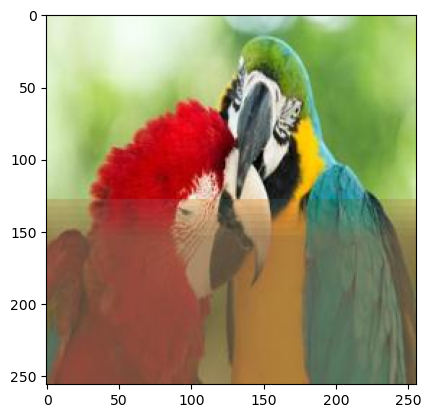

In [30]:
kk = cv2.imread("loritos_jesus_2.jpeg")
kk = cv2.cvtColor(kk, cv2.COLOR_BGR2RGB)/255.
plt.imshow(kk)
plt.show()
kk = kk[None,:]

In [31]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [32]:
%%time
outputs, extras = forward_intermediates(state, kk)
outputs.shape

CPU times: user 7.07 s, sys: 98.9 ms, total: 7.17 s
Wall time: 1.73 s


(1, 64, 64, 128)

### Gamma Correction

In [33]:
if config.USE_GAMMA: layer_name = "GDNGamma_0"
else: layer_name = "GDN_0"
state.params[layer_name]

FrozenDict({
    bias: Array([0.1], dtype=float32),
    kernel: Array([0.5], dtype=float32),
})

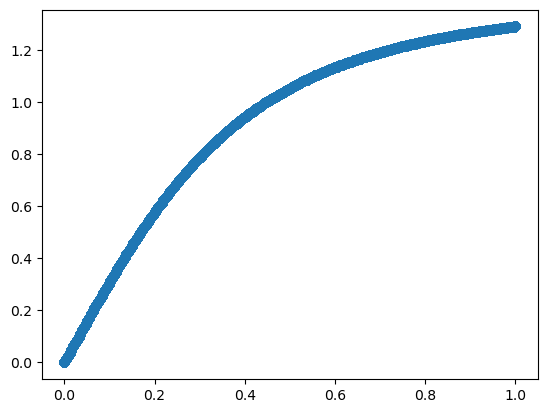

In [34]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

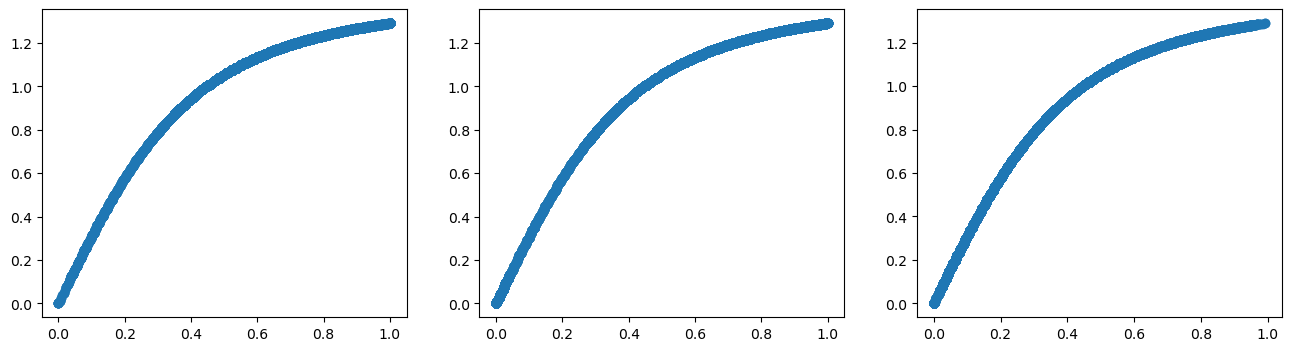

In [35]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, ax in enumerate(axes.ravel()):
    ax.scatter(kk[...,i].ravel(),
            extras["intermediates"][layer_name]["__call__"][0][...,i].ravel())
plt.show()

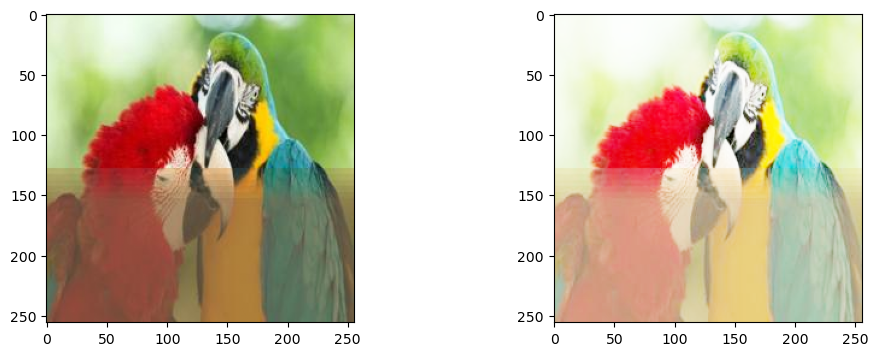

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][layer_name]["__call__"][0][0]/extras["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

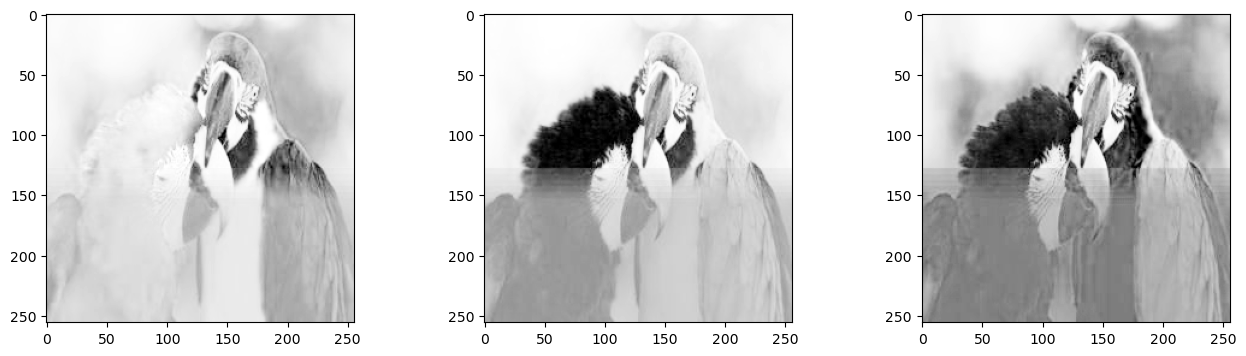

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [38]:
if config.USE_GAMMA: prev_layer = "GDNGamma_0"
else: prev_layer = "GDN_0"
layer_name = "Color"

In [39]:
state.params["Color"]

FrozenDict({
    kernel: Array([[[[ 0.23877808,  0.18420002,  0.08732468],
             [ 0.70840997, -0.3874116 ,  0.25237116],
             [ 0.09975312,  0.18525615, -0.37621233]]]], dtype=float32),
})

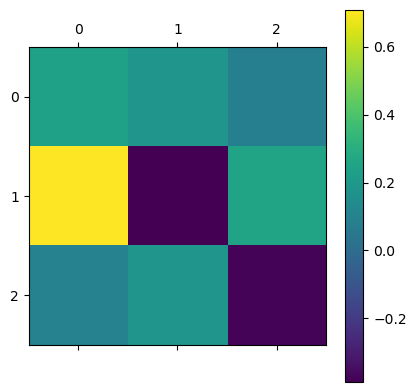

In [40]:
plt.matshow(state.params["Color"]["kernel"][0,0])
plt.colorbar()
plt.show()

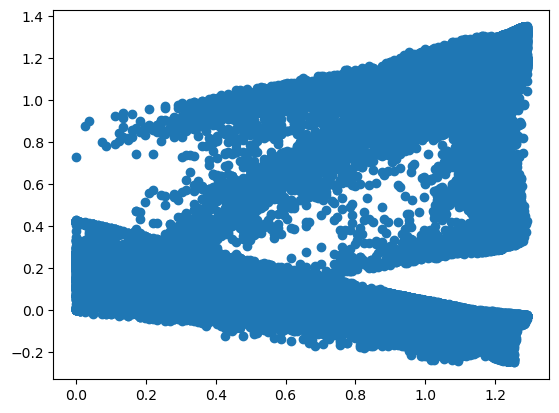

In [41]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

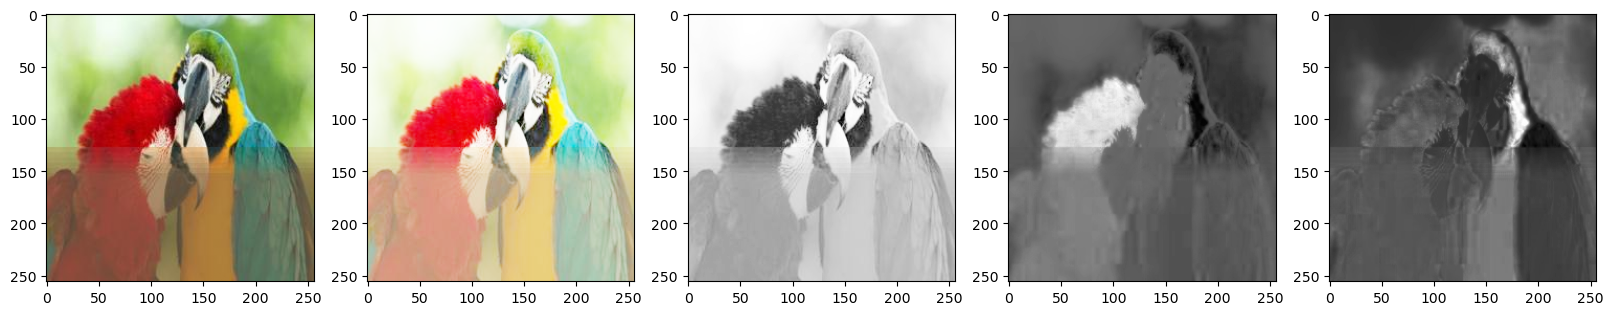

In [42]:
fig, axes = plt.subplots(1, 5, figsize=(20,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][prev_layer]["__call__"][0][0]/extras["intermediates"][prev_layer]["__call__"][0][0].max())
for i, ax in enumerate(axes[2:]):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [43]:
# prev_layer = "Conv_0"
prev_layer = "Color"
if config.USE_GAMMA: layer_name = "GDN_0"
else: layer_name = "GDN_1"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: Array([1., 1., 1.], dtype=float32),
        kernel: Array([[[[0.33333334, 0.33333334, 0.33333334]]]], dtype=float32),
    },
})

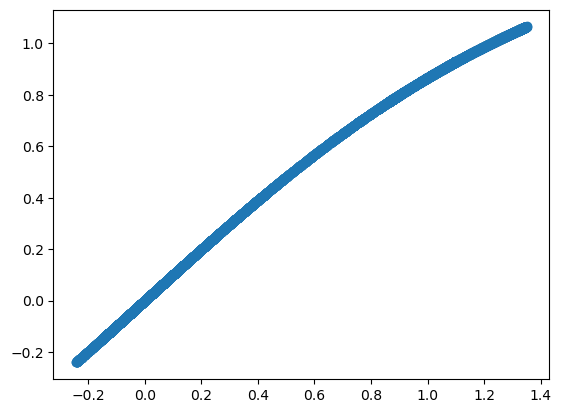

In [44]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

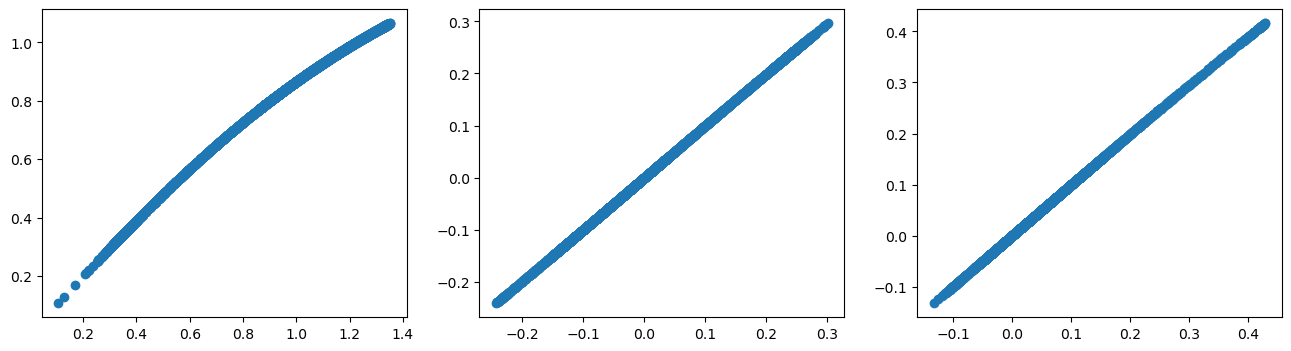

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [46]:
prev_layer = "GDN_1"
layer_name = "CenterSurroundLogSigmaK_0"
state.params[layer_name]

FrozenDict({
    A: Array([1., 0., 0., 0., 1., 0., 0., 0., 1.], dtype=float32),
    K: Array([1.1, 1.1, 1.1, 5. , 5. , 5. , 5. , 5. , 5. ], dtype=float32),
    logsigma: Array([-1.9 , -1.9 , -1.9 , -1.76, -1.76, -1.76, -1.76, -1.76, -1.76],      dtype=float32),
})

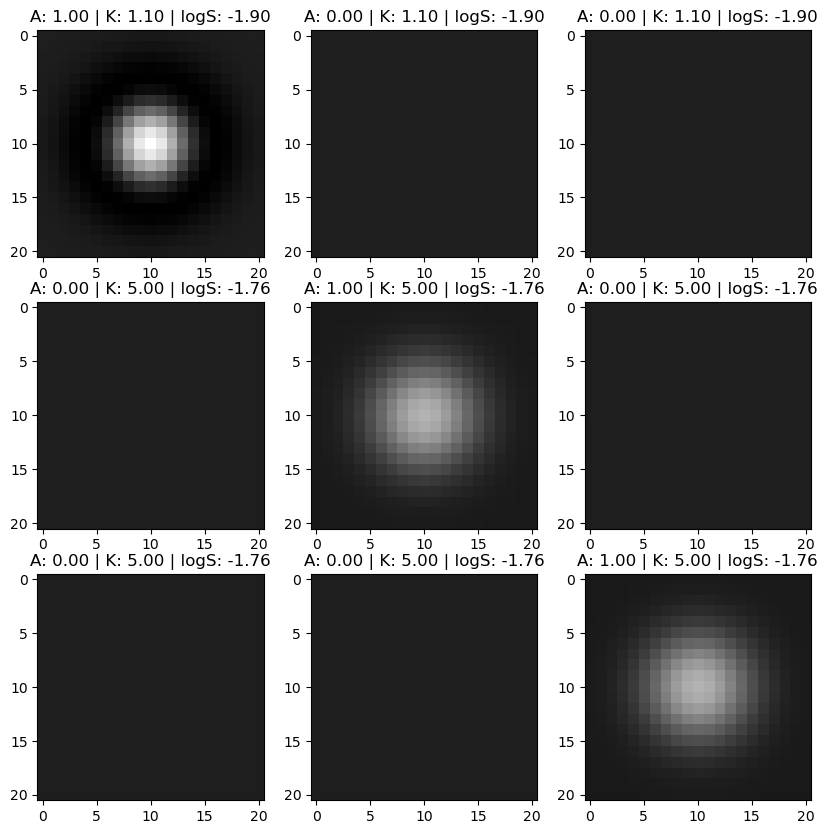

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

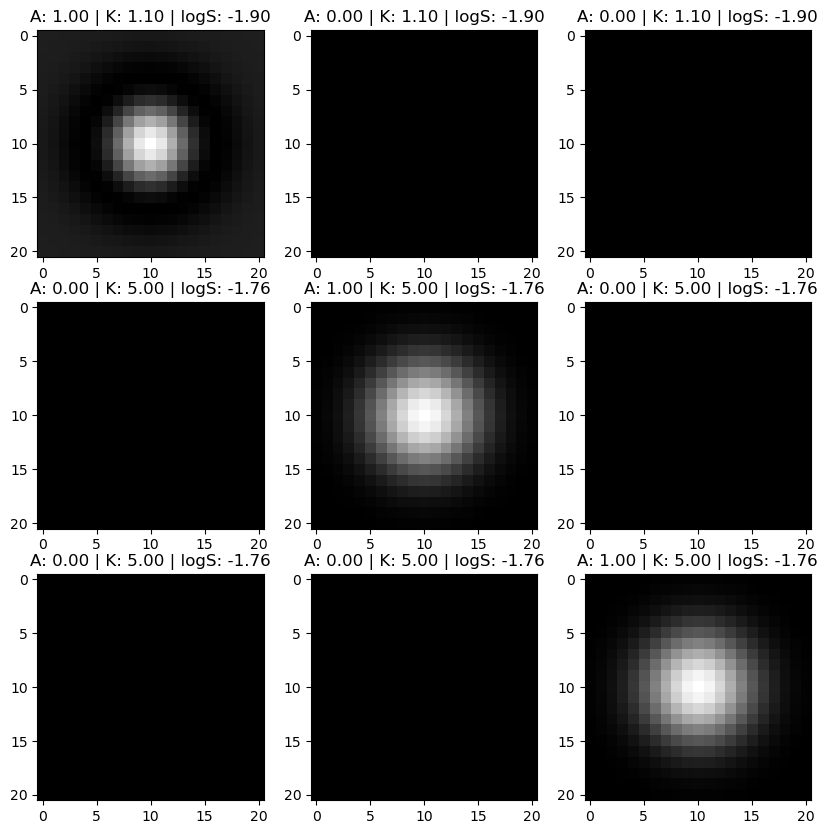

In [48]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [49]:
prev_layer = "CenterSurroundLogSigmaK_0"
layer_name = "GDNGaussian_0"
state.params[layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: Array([1., 1., 1.], dtype=float32),
        bias: Array([0.1, 0.1, 0.1], dtype=float32),
        gamma: Array([25., 25., 25.], dtype=float32),
    },
})

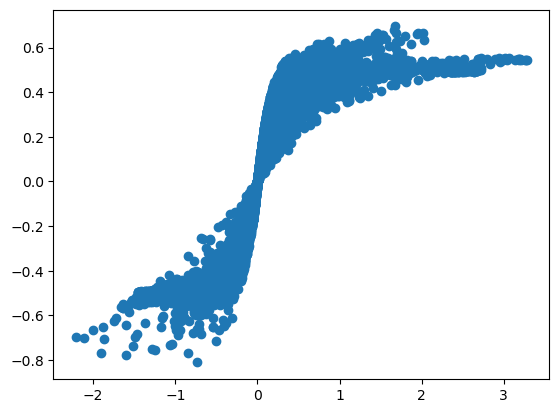

In [50]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

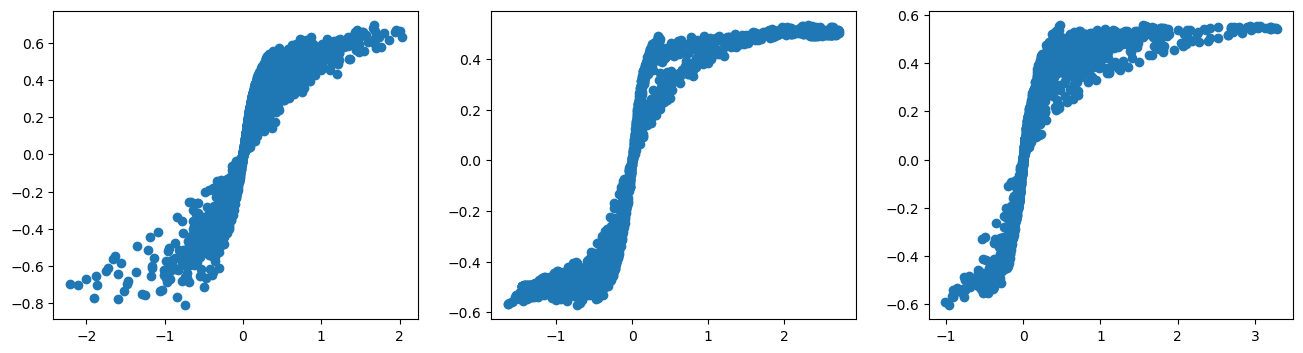

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

In [52]:
state.params["GDNGaussian_0"]

FrozenDict({
    GaussianLayerGamma_0: {
        A: Array([1., 1., 1.], dtype=float32),
        bias: Array([0.1, 0.1, 0.1], dtype=float32),
        gamma: Array([25., 25., 25.], dtype=float32),
    },
})

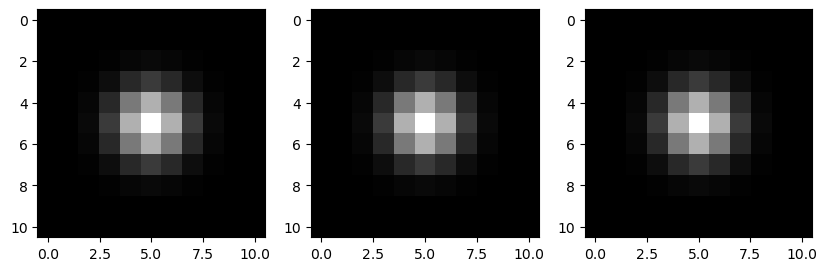

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

In [54]:
state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,0].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,1].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,2].sum()

(Array(4.124962, dtype=float32),
 Array(4.124962, dtype=float32),
 Array(4.124962, dtype=float32))

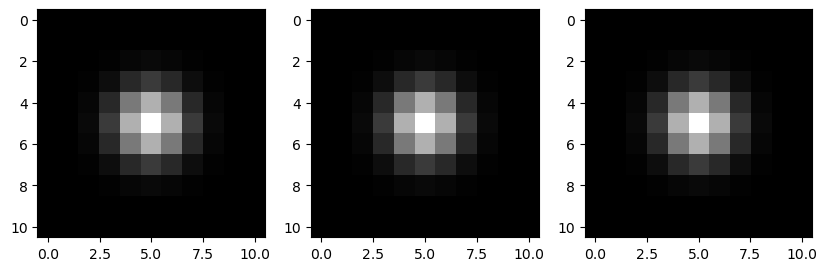

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### Gabor

In [58]:
prev_layer = "GDNGaussian_0"
layer_name = "GaborLayerGammaHumanLike__0"
state.params[layer_name]

FrozenDict({
    A: Array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

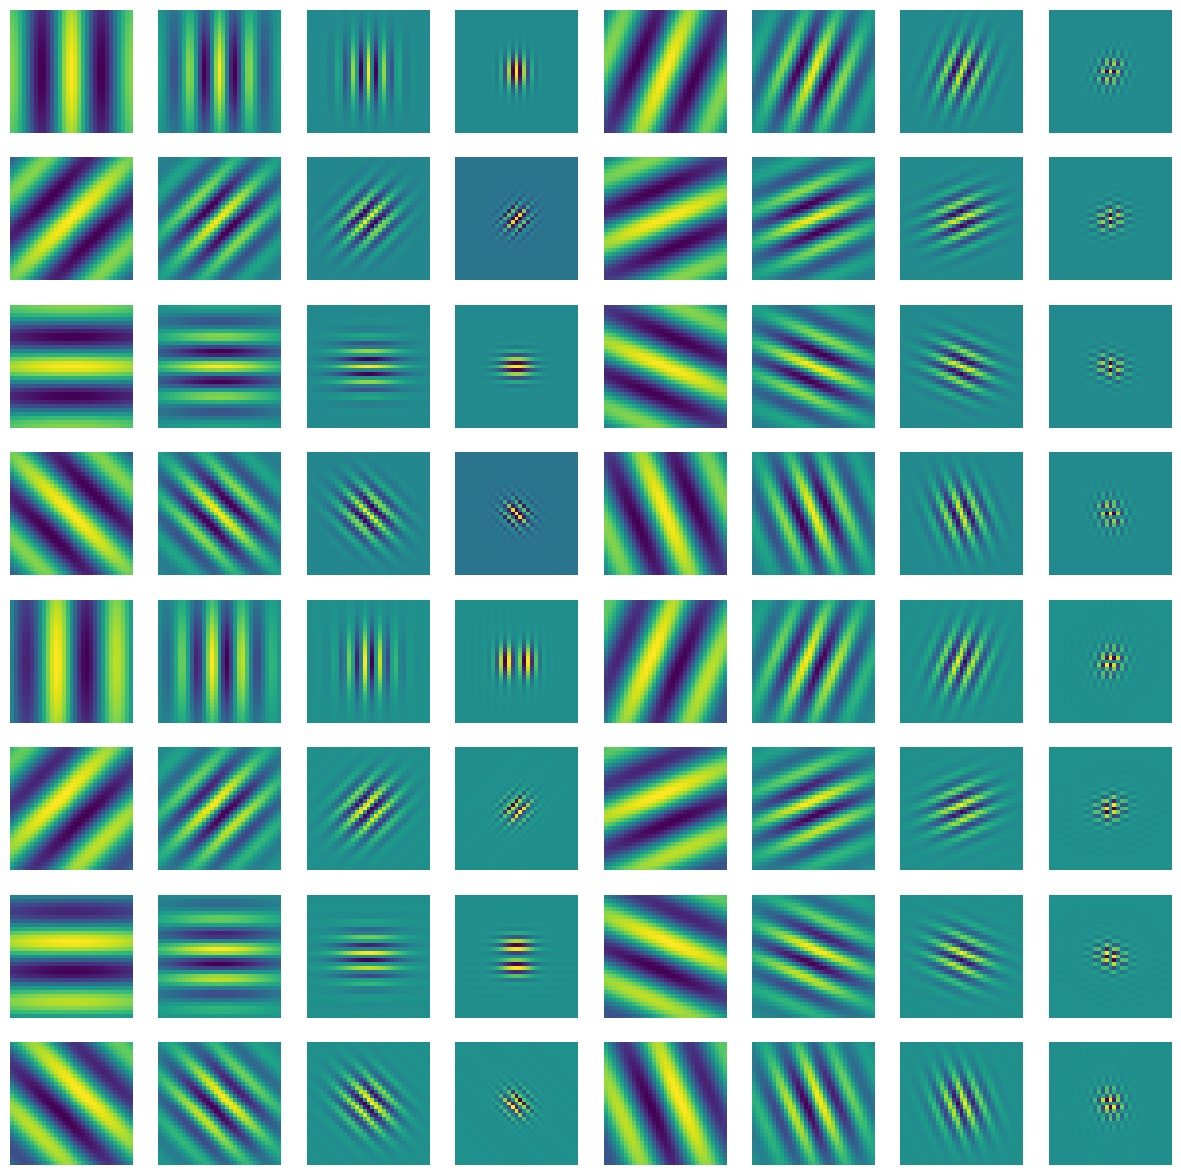

In [59]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

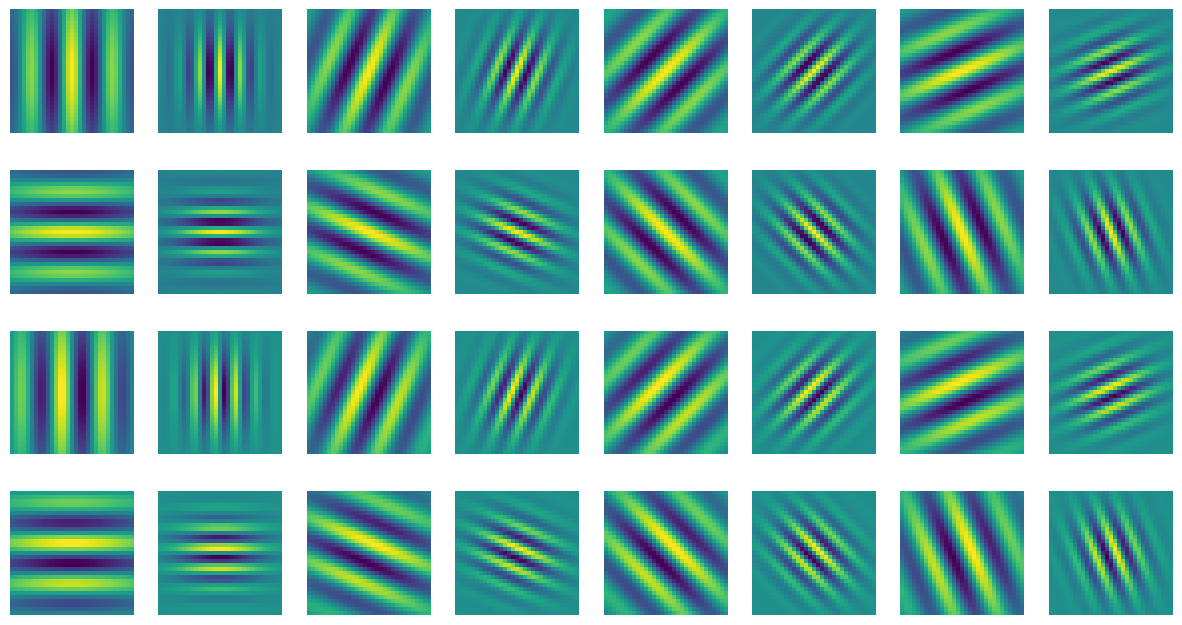

In [62]:
fig, axes = plt.subplots(4,8, figsize=(15,8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,1,i+64])
    ax.axis("off")
plt.show()

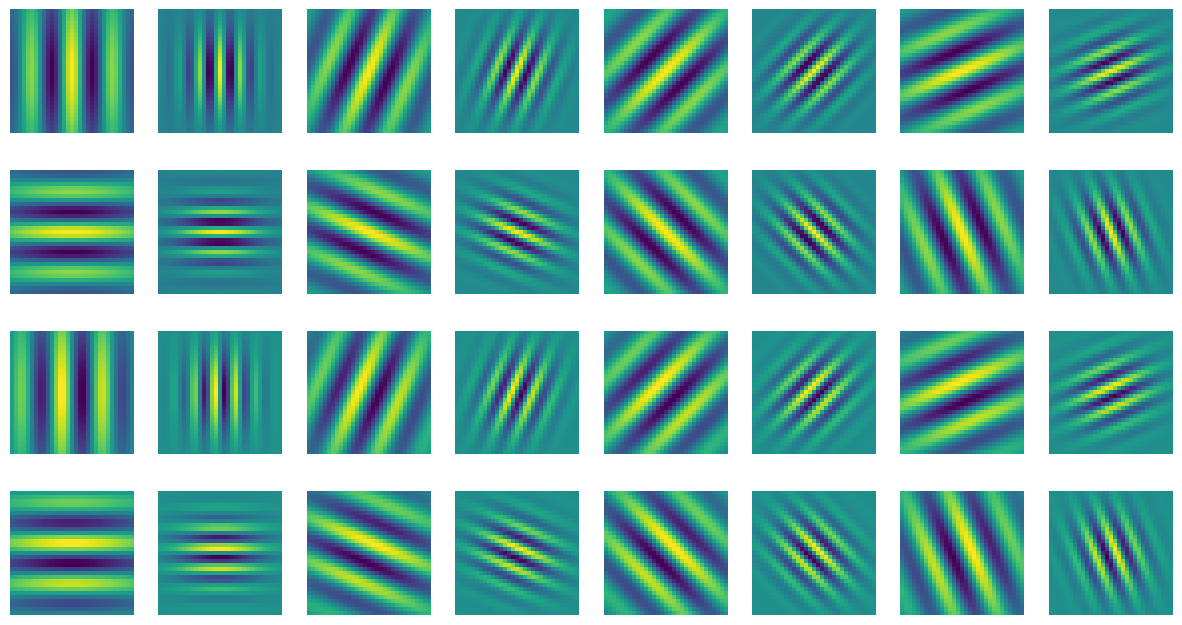

In [63]:
fig, axes = plt.subplots(4,8, figsize=(15,8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,2,i+64+32])
    ax.axis("off")
plt.show()

In [64]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(31, 31, 3, 128)

In [65]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 128), (31, 31))

In [66]:
# fig, axes = plt.subplots(8,8, figsize=(15,15))
# for i, ax in enumerate(axes.ravel()):
#     ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
#     ax.axis("off")
# plt.show()

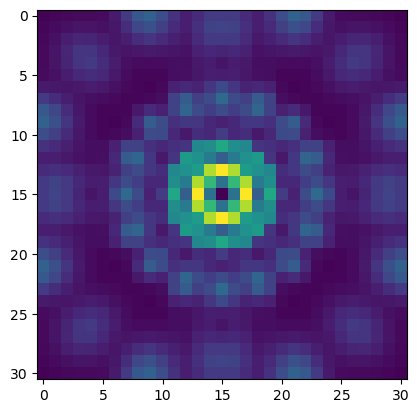

In [67]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

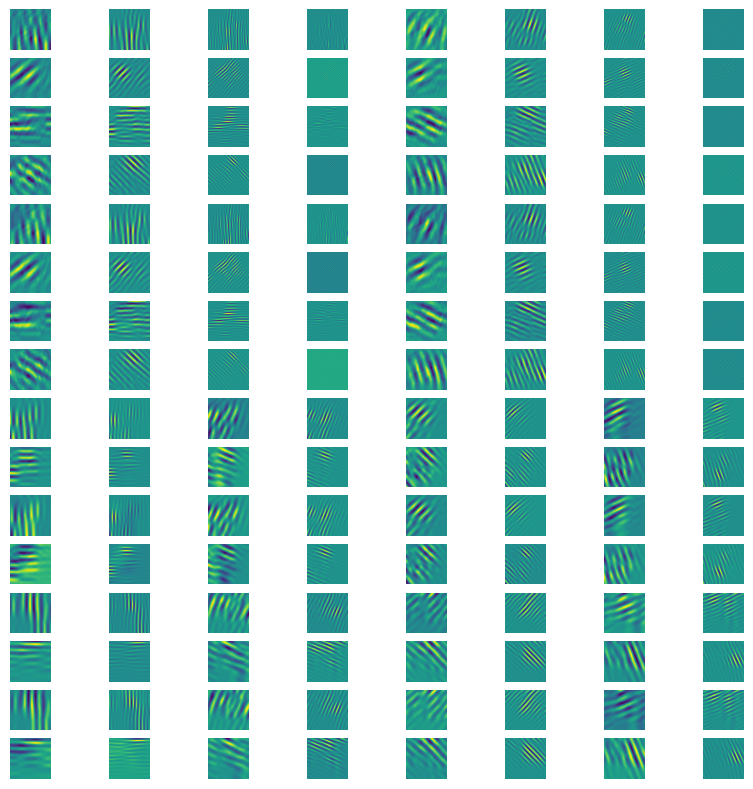

In [70]:
fig, axes = plt.subplots(16, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0][0,:,:,i])
    ax.axis("off")
plt.show()
plt.show()

### DN (3)

In [72]:
prev_layer = "GaborLayerGammaHumanLike__0"
layer_name = "GDNSpatioChromaFreqOrient_0"
state.params[layer_name]

FrozenDict({
    B: Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
    ChromaFreqOrientGaussianGamma_0: {
        H_cc: Array([[1., 0., 0.],
               [0., 1., 0.],
               [0., 0., 1.]], dtype=float32),
        gamma_f_a: Array([1.25   , 0.625  , 0.3125 , 0.15625], dtype=float32),
        gamma_f_d: Array([0.8333333 , 0.41666666], dtype=float32),
        gamma_f_t: Array([0.8333333 , 0.41666666], dtype=float32),
     

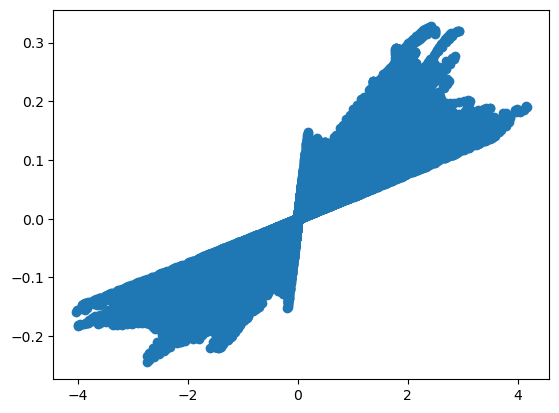

In [73]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

In [74]:
extras["intermediates"][prev_layer]["__call__"][0][0].shape

(1, 64, 64, 128)

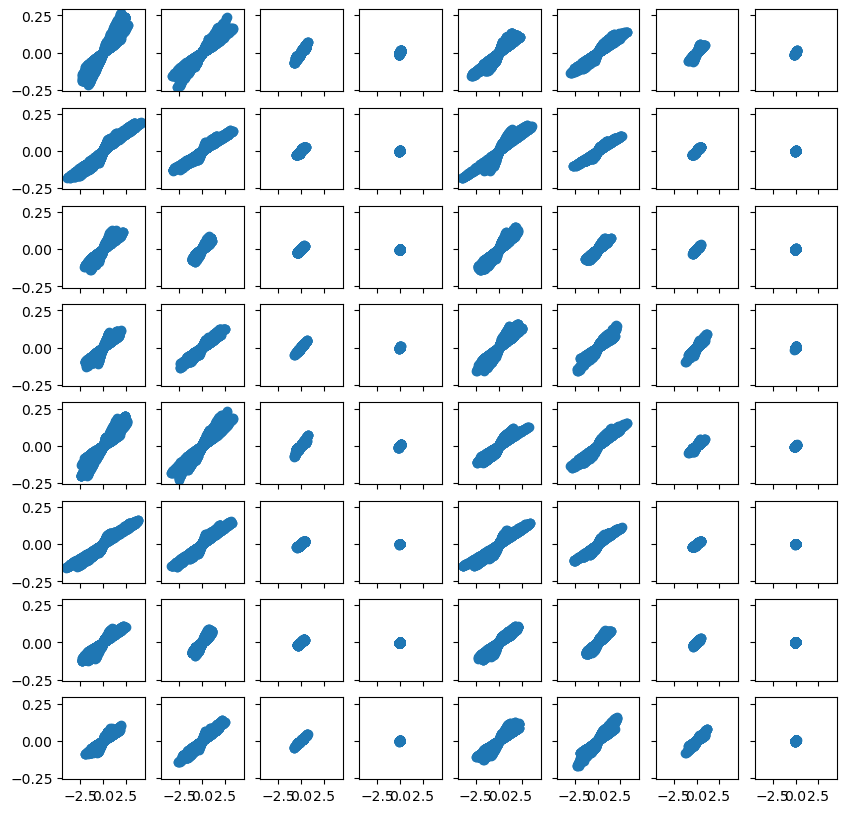

In [75]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.scatter(extras["intermediates"][prev_layer]["__call__"][0][0][0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()
plt.show()

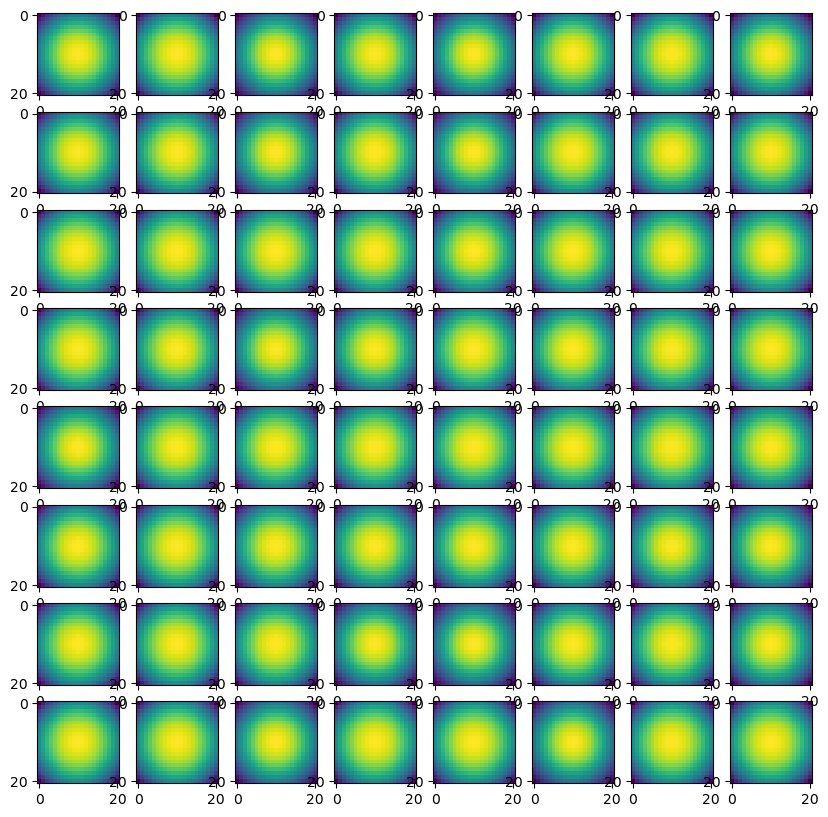

In [77]:
fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,i])
plt.show()

In [80]:
print(state.params[prev_layer]["freq_a"])
print(state.params[prev_layer]["freq_t"])
print(state.params[prev_layer]["freq_d"])

[ 2.  4.  8. 16.]
[3. 6.]
[3. 6.]


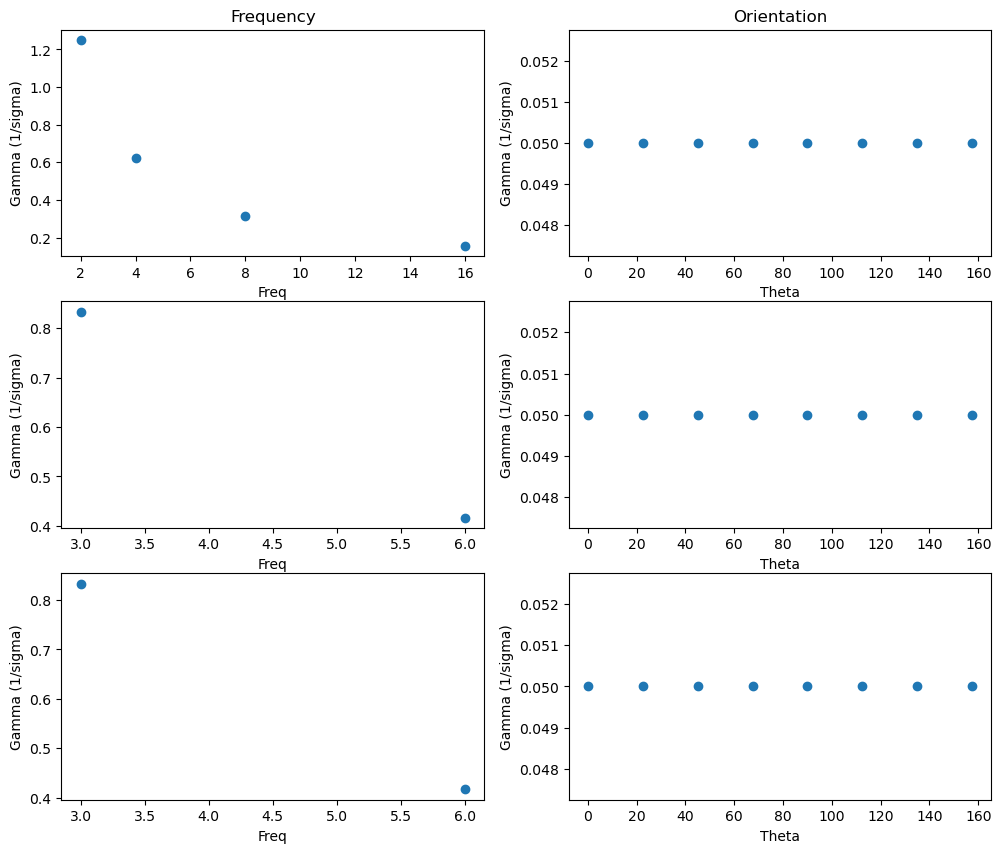

In [88]:
fig, axes = plt.subplots(3,2, figsize=(12,10))
axes[0,0].scatter(state.params[prev_layer]["freq_a"], state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_f_a"])
axes[0,0].set_xlabel("Freq")
axes[0,0].set_ylabel("Gamma (1/sigma)")
axes[0,0].set_title("Frequency")


axes[1,0].scatter(state.params[prev_layer]["freq_t"], state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_f_t"])
axes[1,0].set_xlabel("Freq")
axes[1,0].set_ylabel("Gamma (1/sigma)")
# axes[1,0].set_title("Frequency")

axes[2,0].scatter(state.params[prev_layer]["freq_d"], state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_f_d"])
axes[2,0].set_xlabel("Freq")
axes[2,0].set_ylabel("Gamma (1/sigma)")
# axes[2,0].set_title("Frequency")

axes[0,1].scatter(state.params[prev_layer]["theta_a"]*180/jnp.pi, state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_a"])
axes[0,1].set_xlabel("Theta")
axes[0,1].set_ylabel("Gamma (1/sigma)")
axes[0,1].set_title("Orientation")

axes[1,1].scatter(state.params[prev_layer]["theta_t"]*180/jnp.pi, state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_t"])
axes[1,1].set_xlabel("Theta")
axes[1,1].set_ylabel("Gamma (1/sigma)")
# axes[1,1].set_title("Orientation")

axes[2,1].scatter(state.params[prev_layer]["theta_d"]*180/jnp.pi, state.params[layer_name]["ChromaFreqOrientGaussianGamma_0"]["gamma_theta_d"])
axes[2,1].set_xlabel("Theta")
axes[2,1].set_ylabel("Gamma (1/sigma)")
# axes[2,1].set_title("Orientation")

plt.show()

### Final output

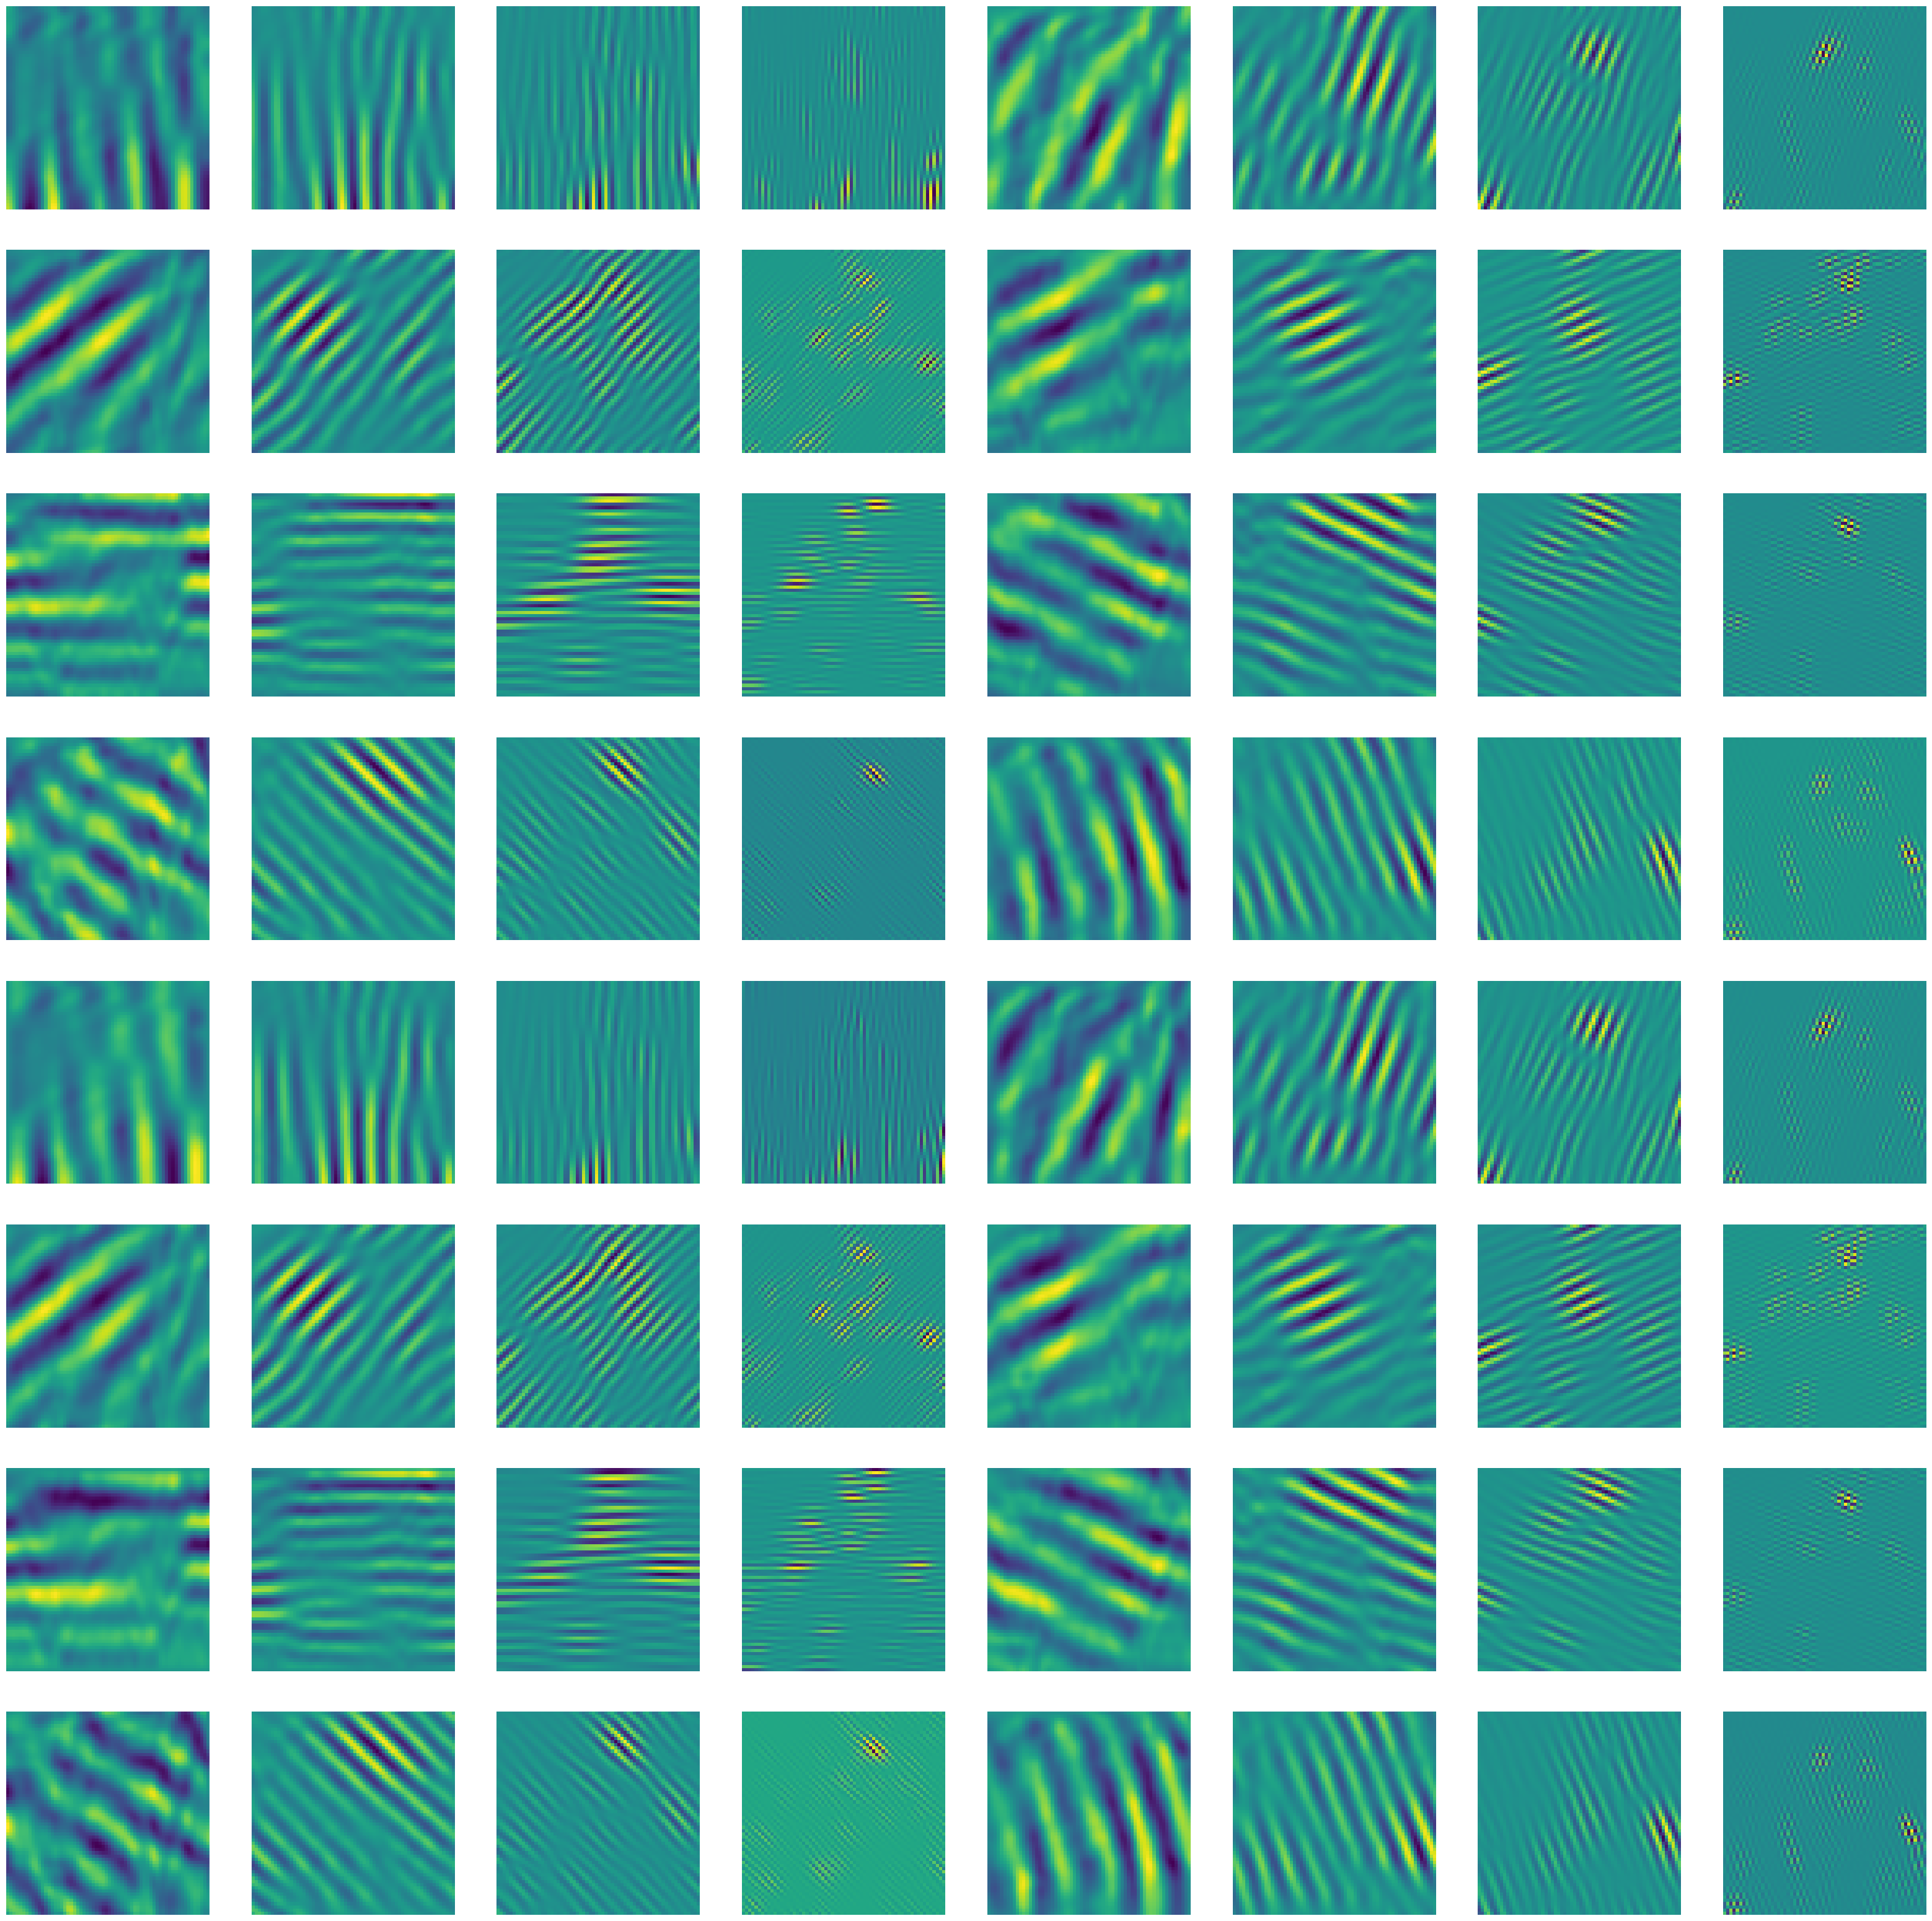

In [89]:
fig, axes = plt.subplots(8,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()

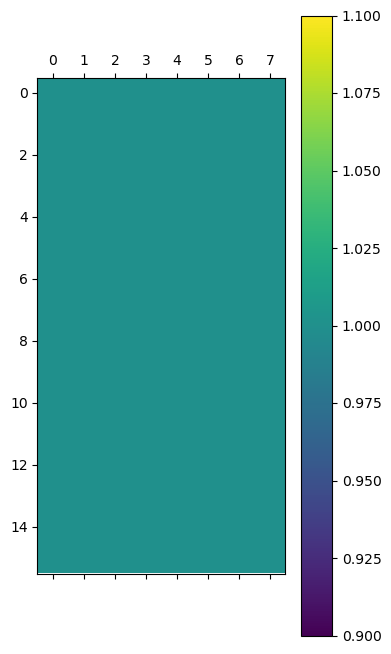

In [91]:
import matplotlib.pyplot as plt
m = state.params["GDNSpatioChromaFreqOrient_0"]["B"]
m = rearrange(m, "(h w) -> h w", h=16, w=8)
plt.matshow(m)
plt.colorbar()
plt.show()